In [1]:
%matplotlib inline

## Audio processing, Video processing and Computer vision
## Bachelor in Data Science and Engineering - Universidad Carlos III de Madrid

# LAB SESSION 4: IMAGE CLASSIFICATION WITH CNNs

# AUTOMATIC DIAGNOSTIC SYSTEM OF SKIN LESSIONS FROM DERMOSCOPIC IMAGES


### Iván González Díaz

**Authors of homework:**
+ David Stych
+ Aleksandra Jamróz

<center><img src='http://www.tsc.uc3m.es/~igonzalez/images/logo_uc3m_foot.jpg' width=400 /></center>


In this practice we are going to build a skin lesion diagnosis system based on dermoscopic image analysis.

## Part 0: The problem

Before starting the practice, we will briefly describe the database that we will use and the problem we aim to address:

Our goal is to develop a CNN providing an automatic diagnosis of cutaneous diseases from dermoscopic images. Dermoscopy is a non-invasive technique that allows the evaluation of the colors and microstructures of the epidermis, the dermoepidermal joint and the papillary dermis that are not visible to the naked eye. These structures are specifically correlated with histological properties of the lesions. Identifying specific visual patterns related to color distribution or dermoscopic structures can help dermatologists decide the malignancy of a pigmented lesion. The use of this technique provides a great help to the experts to support their diagnosis. However, the complexity of its analysis limits its application to experienced clinicians or dermatologists.

In our scenario, we will consider 3 classes of skin lesions:

- Malignant melanoma: Melanoma, also known as malignant melanoma, is the most common type of cancer, and arises from pigmented cells known as melanocytes. Melanomas typically occur on the skin and rarely elsewhere such as the mouth, intestines, or eye.

- Seborrheic keratosis: it is a noncancerous (benign) tumor of the skin that originates from the cells of the outer layer of the skin (keranocytes), so it is a non-melanocytic lesion.

- Benign nevus: a benign skin tumor caused by melanocytes (it is melanocytic)

Figure 1 shows a visual example of the 3 considered lesions:

![Image of ISIC](http://www.tsc.uc3m.es/~igonzalez/images/ISIC.jpg)

The dataset has been obtained from the 'Internatial Skin Imaging Collaboration' (ISIC) file. It contains 2750 images divided into 3 sets:
- Training set: 2000 images
- Validation set: 150 images
- Test set: 600 images

For each clinical case, two images are available:
- The dermoscopic image of the lesion (in the ‘images’ folder).
- A binary mask with the segmentation between injury (mole) and skin (in the 'masks' folder)

Additionally, there is a csv file for each dataset (training, validation and test) in which each lines corresponds with a clinical case, defined with two fields separated by commas:
- the numerical id of the lesion: that allows to build the paths to the image and mask.
- the lesion label: available only for training and validation, being an integer between 0 and 2: 0: benign nevus, 1: malignant melanoma, 2: seborrheic keratosis. In the case of the test set, labels are not available (their value is -1).

Students will be able to use the training and validation sets to build their solutions and finally provide the scores associated with the test set. This practice provides a guideliness to build a baseline reference system. To do so, we will learn two fundamental procedures:

- 1) Process your own database with pytorch
- 2) Fine-tuning a regular network for our diagnostic problem

## Part 1: Handling our custom dataset with pytorch
Now we are going to study how we can load and process our custom dataset in pytorch. For that end, we are going to use the package ``scikit-image`` for reading images, and the package ``panda`` for reading csv files.


In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

In [4]:
random.seed(42)
npr.seed(42)
torch.manual_seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The first thing we need to do is to download and decompress the dataset on a local folder:




In [ ]:
# ONLY TO USE GOOGLE COLAB. Run this code only the first time you run this notebook and then comment these lines
# from shutil import copyfile
# from google.colab import drive
# import os, sys
# drive.mount('/content/drive')
# copyfile('/content/drive/My Drive/Colab Notebooks/s4/db1.zip', './db1.zip') #Copy db files to our working folder
# copyfile('/content/drive/My Drive/Colab Notebooks/s4/db2.zip', './db2.zip')


In [5]:
# #NOTE: Run this only once, in the machine where you want to run your code, then comment these lines
# import zipfile
# zipPath = './db1.zip' # path of the 1st zip file
# dataFolder = './data' # We extract files to the current folder
# with zipfile.ZipFile(zipPath, 'r') as zip_ref:
#     zip_ref.extractall(dataFolder)
    
# zipPath = './db2.zip' #path of the 2nd zip file
# dataFolder = './data' # We extract files to the current folder
# with zipfile.ZipFile(zipPath, 'r') as zip_ref:
#     zip_ref.extractall(dataFolder)

Now let's read the indexed file and display data from image 65. The file structure is one row per image of the database, and two fields:
- Image ID (a 4-digit sequence, adding 0 to the left side if required)
- Label: 0 benign nevus, 1 melanoma, 2 seborrheic keratosis



In [6]:
db = pd.read_csv('data/dermoscopyDBtrain.csv',header=0,dtype={'id': str, 'label': int})

# We show inform
n = 65
img_id = db.id[65] 
label = db.label[65]

print('Image ID: {}'.format(img_id))
print('Label: {}'.format(label))

Image ID: 0066
Label: 0


Now, let's create a simple function to show an image.




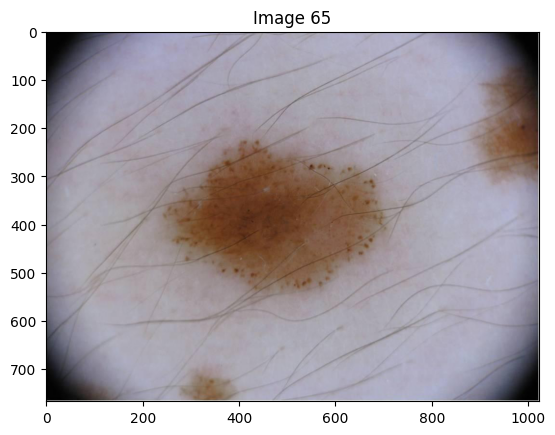

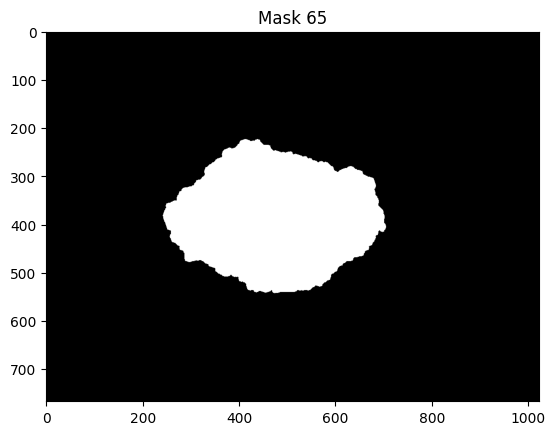

In [7]:
def imshow(image, title_str):
    if len(image.shape)>2:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=plt.cm.gray)
    plt.title(title_str)        

plt.figure()
imshow(io.imread(os.path.join('data/images/', img_id + '.jpg' )),'Image %d'%n)
plt.figure()
imshow(io.imread(os.path.join('data/masks/', img_id + '.png')),'Mask %d'%n)

plt.show()

### Class Dataset

The class `` torch.utils.data.Dataset`` is an abstract class that represents a dataset.

To create our custom dataset in pytorch we must inherit from this class and overwrite the following methods:

- `` __len__`` so that `` len (dataset) `` returns the size of the dataset.
- `` __getitem__`` to support indexing `` dataset [i] `` when referring to sample $i$

We are going to create the train and test datasets of our diagnostic problem. We will read the csv in the initialization method `` __init__`` but we will leave the explicit reading of the images for the method
`` __getitem__``. This approach is more efficient in memory because all the images are not loaded in memory at first, but are read individually when necessary.

Our dataset is going to be a dictionary `` {'image': image, 'mask': mask, 'label': label} ``. You can also take an optional `` transform '' argument so that we can add pre-processing and data augmentation techniques.



In [8]:
class DermoscopyDataset(Dataset):
    """Dermoscopy dataset."""

    def __init__(self, csv_file, root_dir, transform=None, maxSize=0):
        """
        Args:
            csv_file (string): Path to csv file with notes.
            root_dir (string): Root directory where we will find the 'images' and 'masks' folders .
            transform (callable, optional): Optional transformations to perform on the images.
        """
        self.dataset = pd.read_csv(csv_file,header=0,dtype={'id': str, 'label': int})
        
        if maxSize > 0:
            newDatasetSize = maxSize # maxSize samples
            idx = np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset = self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset = reduced_dataset.reset_index(drop = True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir,'images') 
        self.mask_dir = os.path.join(root_dir,'masks')
        self.transform = transform
        self.classes = ['nevus', 'melanoma', 'keratosis']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Reading an image
        img_name = os.path.join(self.img_dir,self.dataset.id[idx] + '.jpg')
        image = io.imread(img_name)
        # Reading the mask
        mask_name = os.path.join(self.mask_dir,self.dataset.id[idx] + '.png')
        mask = io.imread(mask_name)
        
        sample = {'image': image, 'mask': mask, 'label':  self.dataset.label[idx].astype(dtype=np.long)}
        if self.transform:
            sample = self.transform(sample)
        return sample

We now instantiate the class to iterate over some samples to see what we generate.


0 (767, 1022, 3) 0
1 (767, 1022, 3) 0
2 (767, 1022, 3) 1
3 (767, 1022, 3) 0


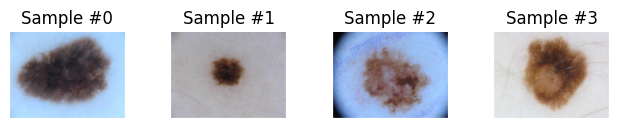

In [9]:
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data')

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

**IMPORTANT**

The optional parameter ``maxSize`` in the constructor allows us to subsample the number of images and consequently reduce the size of the dataset. If not set included or maxSize=0, then the dataset will include all the images. This parameter is useful to train models over smaller datasets during hyperparameter validation and design phases. Working with less images reduces the training time at the expense of obtaining results that may deviate from those obtained with the full dataset size. Of course, the larger the training dataset, the more stable results but the larger the training time. Hence, it is up to the students the use of this parameter. 

### Data pre-processing and Augmentation: Transforms
----------

In the previously shown examples we can see that the size of the images is not the same. This would prevent to train a red convolutional neuronal, as the vast majority require fixed-size inputs. Furthermore, the image is not always adjusted to the lesion, and indeed, in some examples lesions are very small compared to the size of the image. It would then be desirable to adjust the input images so that the lesion covers almost the entire image.

To do this, we are going to create some preprocessing code, focusing on 5 transformations:

- `` CropByMask``: to crop the image using the lesion mask
- `` Rescale``: to scale the image
- `` RandomCrop``: to crop the image randomly, it allows us to augment the data samples with random crops
-  ``CenterCrop``: to perform a central crop of the image with the indicated size (useful in test)
- `` ToTensor``: to convert numpy matrices into torch tensors (rearranging the axes).

We will define them as callable classes instead of simple functions, as we will not need to pass the transform  parameters every time we call a method. To do this, we only have to implement the `` __call__`` method and, if necessary, the `` __init__`` method.
Then we can use a transformation with the following code:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)


In [11]:
class CropByMask(object):
    """
    Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding 
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border
            
    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'], sample['label']
        h, w = image.shape[:2]
        # Compute the coordinates of the bounding box that contains the mask 
        sidx = np.nonzero(mask)
        minx = np.maximum(sidx[1].min() - self.border[1], 0)
        maxx = np.minimum(sidx[1].max() + 1 + self.border[1], w)
        miny = np.maximum(sidx[0].min() - self.border[0], 0)
        maxy = np.minimum(sidx[0].max() + 1 + self.border[1], h)
        # Crop the image
        image = image[miny:maxy, minx:maxx,...]
        mask = mask[miny:maxy, minx:maxx]

        return {'image': image, 'mask': mask, 'label' : label}
    

class Rescale(object):
    """
    Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size. 
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'label' : label}


class RandomCrop(object):
    """
    Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0
            
        if w>new_w: 
            left = np.random.randint(0, w - new_w)
        else:
            left = 0
            
        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}
    

class CenterCrop(object):
    """
    Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w
        
        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0
            
        if w>new_w: 
            left = int(rem_w/2)
        else:
            left = 0
            
        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'label': label}


class ToTensor(object):
    """Convert ndarrays into pytorch tensors."""

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        # We change the axes
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        # To the mask we add a fake dim at the beginning
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        
        return {'image':image,
                'mask':mask,
                'label':label}
    
    
class Normalize(object):
    """Normalize data by subtracting means and dividing by standard deviations.

    Args:
        mean_vec: Vector with means. 
        std_vec: Vector with standard deviations.
    """

    def __init__(self, mean,std):
      
        assert len(mean)==len(std),'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']
        c, h, w = image.shape
        assert c==len(self.mean), 'Length of mean and image is not the same' 
        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        image.sub_(mean[:, None, None]).div_(std[:, None, None])
    
        
        return {'image': image, 'mask': mask, 'label' : label}


### Exercise:

Use the following code to apply the previous transforms and experiment with the values of the parameters to study their influence. Read the documentation at the begining of each class to understand the sintaxis of the input parameters.


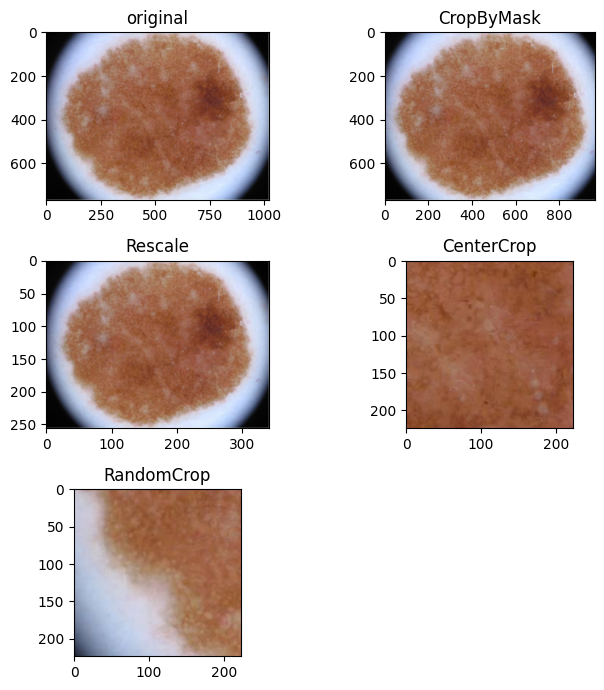

In [18]:
### Modify this code to make your experiments....

cmask = CropByMask(50)      # border width surrounding the mask
scale = Rescale(256)        # smallest dim - aspect ratio is kept
rcrop = RandomCrop(224)     # square box size
ccrop = CenterCrop(224)     # square box size

# Apply each of the above transforms on sample.
fig = plt.figure(figsize=(7,7))
sample = train_dataset[65]          # pic idx
ax = plt.subplot(3, 2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])
    
for i, tsfrm in enumerate([cmask, scale, ccrop, rcrop]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(3, 2, i+2)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

#### Using package torchvision.transforms

Package torchvision.trasforms comes with many useful methods that implement valuable transforms for data augmentation. Those transforms can be applied either to torch.tensors or to images. However, torchvision uses PIL library to read and process images, in contrast to the matrix representation of images used in scikit-image library (the library we have used in the previous methods). Furthermore, some of the transforms affect both to input images and skin-lesion masks, which avoid applying them to our samples. Hence, in order to use a torchvision transform we need to implement a pipeline that:

- 1) First, convert the matrix-based images to PILImages
- 2) Apply the transform to PILImages
- 3) Convert PILImages to matrices

And applies these to input images and, if necessary, to the binary skin-lesion masks. The following class ``TVCenterCrop`` implements the same functionality as the previous ``CenterCrop``, but using the corresponding method in torchvision. It is therefore a useful example if you plan to make use of torchvision transforms.


In [19]:
class TVCenterCrop(object):
    """
    Crop the central area of the image. Example using the method in torchvision. Requires to
    internally convert from skimage (numpy array) to PIL Image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, size):
        self.CC = transforms.CenterCrop(size)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_image = self.CC(pil_image)
        image = util.img_as_float(np.asarray(pil_image))
        
        pil_mask = Image.fromarray(util.img_as_ubyte(mask))
        pil_mask = self.CC(pil_mask)
        mask = util.img_as_float(np.asarray(pil_mask))
        
        return {'image': image, 'mask': mask, 'label': label}


Now, we apply the transform to check its behavior

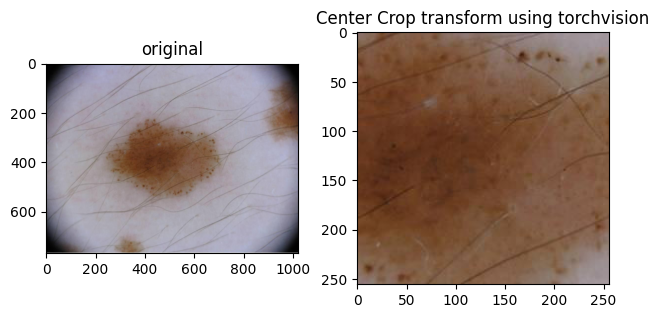

In [21]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc = TVCenterCrop(256)

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise

Implement other transforms using torchvision package. Take TVCenterCrop as guide.

In [ ]:
### Put your code here.... (cells below)

# Notes:

# AVAILABLE TORCH TRANSFORMS:
# https://pytorch.org/vision/0.9/transforms.html#

# Recommended by kaggle: (XD):
# transforms.RandomRotation(30),
# transforms.RandomResizedCrop(224),
# transforms.RandomHorizontalFlip(),

# At the end we have to scale the images to the same size

# also kaggle but idk
# https://www.kaggle.com/code/jaytee691/melanoma-cnn-pytorch-f1-score-92
# transform = transforms.Compose([transforms.Resize((227, 227)),
                                # transforms.ToTensor(),
                                # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# another website:
# https://ngoc-pham.medium.com/skin-cancer-classification-with-transfer-learning-in-pytorch-389254e39ac1
# train_ts = transforms.Compose([
      # transforms.RandomRotation(30),
      # transforms.RandomResizedCrop(224),
      # transforms.RandomHorizontalFlip(),
      # transforms.ToTensor(),
      # transforms.Normalize([0.485, 0.456, 0.406],
                        #    [0.229, 0.224, 0.225])])
# test_ts = transforms.Compose([
      # transforms.Resize(255),
      # transforms.CenterCrop(224),
      # transforms.ToTensor(),
      # transforms.Normalize([0.485, 0.456, 0.406],
                        #    [0.229, 0.224, 0.225])])

In [33]:
class RandomRotation(object):
    """
    Rotate image by random angle. Example using the method in torchvision. Requires to
    internally convert from skimage (numpy array) to PIL Image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, size):
        self.CC = transforms.RandomRotation(size)

    def __call__(self, sample):
        image, mask, label = sample['image'], sample['mask'],sample['label']

        pil_image = Image.fromarray(util.img_as_ubyte(image))
        pil_image = self.CC(pil_image)
        image = util.img_as_float(np.asarray(pil_image))
        
        pil_mask = Image.fromarray(util.img_as_ubyte(mask))
        pil_mask = self.CC(pil_mask)
        mask = util.img_as_float(np.asarray(pil_mask))
        
        return {'image': image, 'mask': mask, 'label': label}


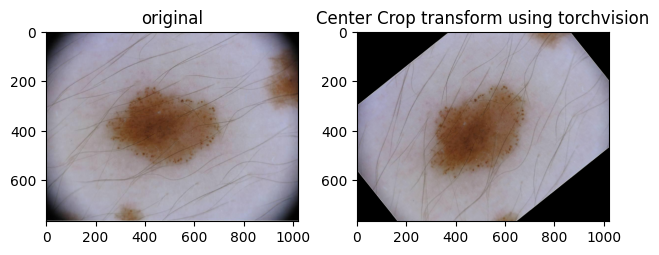

In [34]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])

tvcc = RandomRotation(80)

transformed_sample = tvcc(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Center Crop transform using torchvision')
plt.imshow(transformed_sample['image'])

plt.show()

### Composed Transforms

Now let's apply the different transformations to our images. 

We will rescale the images so that their smallest dimension is 224 and then make random crops of size 224. To compose the transformations ``Rescale`` and ``RandomCrop`` we can use ``torchvision.transforms.Compose``, which is a simple callable class.




In [ ]:
composed = transforms.Compose([CropByMask(15), Rescale(224),RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[65]
ax = plt.subplot(1,2, 1)
plt.tight_layout()
ax.set_title('original')
plt.imshow(sample['image'])
    
transformed_sample = composed(sample)
ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title('Composed transform')
plt.imshow(transformed_sample['image'])

plt.show()

### Exercise:

Use the previous code to test different combinations of transform and discuss the results.


### Exercise:

Data augmentation techniques are useful as long as they model random transforms that may happen in the real world, and so can be found in test. Hence, the choice of the data augmentation techniques to be applied is problem-dependent and may differ from one dataset to another. Have a look at the images in the dataset and try to figure out which transforms are appropriate for these problem. Imagine how a dermatologist takes a dermoscopic picture and which factors may differ from one capture to another. Your results in the challenge will strongly depend on your design!!!!


In [ ]:
### Put your code here....






Iterating the dataset
-----------------------------

We can now put everything together to create the train and test datasets with the corresponding transformations.
In summary, every time we sample an image from the dataset (during training):
- We will read the image and the mask
- We will apply the transformations and we will crop the image using a bounding box computed from the mask
- As the final cropping operation is random, we perform data augmentation during sampling

We can easily iterate over the dataset with a ``for i in range`` loop.




In [ ]:
#Pixel means and stds expected by models in torchvision
pixel_mean=[0.485, 0.456, 0.406]
pixel_std=[0.229, 0.224, 0.225]

#Train Dataset
train_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtrain.csv',
                                    root_dir='data',
                                    maxSize=500, ###IMPORTANT: maxSize=500 to speed-up the training process
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    RandomCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))
#Val dataset
val_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBval.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

#Test dataset
test_dataset = DermoscopyDataset(csv_file='data/dermoscopyDBtest.csv',
                                    root_dir='data',
                                    transform=transforms.Compose([
                                    CropByMask(15),
                                    Rescale(224),
                                    CenterCrop(224),
                                    ToTensor(),
                                    Normalize(mean=pixel_mean,
                                    std=pixel_std)
                                    ]))

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].size(), sample['label'])

    if i == 3:
        break

Finally, we have to create a dataloader allowing to:

- Sample batches of samples to feed the network during training
- Shuffle data
- Load the data in parallel using multiple cores.

``torch.utils.data.DataLoader`` is an iterator that provides all these features. An important parameter of the iterator is ``collate_fn``. We can specify how samples are organized in batches by choosing the most appropriate function. In any case, the default option should work fine in most cases.




In [ ]:
#Specify training dataset, with a batch size of 8, shuffle the samples, and parallelize with 4 workers
train_dataloader = DataLoader(train_dataset, batch_size=16,
                        shuffle=True, num_workers=4)
#Validation dataset => No shuffle
val_dataloader = DataLoader(val_dataset, batch_size=16,
                        shuffle=False, num_workers=4)

#Test Dataset => => No shuffle
test_dataloader = DataLoader(test_dataset, batch_size=16,
                        shuffle=False, num_workers=4)


# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Mostramos las lesiones de un batch."""
    images_batch, labels_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    #Generamos el grid
    grid = utils.make_grid(images_batch)
    #Lo pasamos a numpy y lo desnormalizamos
    grid=grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
        
    #We show the data of the 3rd batch and stop.
    if i_batch == 3:
        break

## Part 2: Fine-tuning a pre-trained model

In the second part of the practice we will build an automatic skin lesion diagnosis system. Instead of training a CNN designed by us from the beginning, we will fine-tune a network that has previously been trained for another task. As seen in the lectures, this usually becomes a good alternative when we do not have many data in the training dataset (in relation to the parameters to be learned).

In particular, we will use the Alexnet CNN, included in the ``torchvision`` package.

### Performance Metric for evaluation
We will start by defining the metric we will use to evaluate our network. In particular, and following the instructions of the organizers of the original ISIC challenge, we will use the area under the ROC or AUC, but we will calculate 3 different AUCs:
- 1) AUC of binary problem melanoma vs all
- 2) AUC of the binary problem seborrheic keratosis vs all
- 3) AUC average of the previous two

The following function computes AUCs from the complete database outputs:



In [ ]:
#Function that computes 2 AUCs: melanoma vs all and keratosis vs all
# scores is nx3: n is the number of samples in the dataset 
# labels is nx1
# Function resturns an array with two elements: the auc values
def computeAUCs(scores,labels):
                
    aucs = np.zeros((2,))
    #Compute the AUC of melanoma vs all
    scores_mel = scores[:,1]
    labels_mel = (labels == 1).astype(np.int) 
    aucs[0]=metrics.roc_auc_score(labels_mel, scores_mel)

    #Compute the AUC of keratosis vs all
    scores_sk = scores[:,2]
    labels_sk = (labels == 2).astype(np.int) 
    aucs[1]=metrics.roc_auc_score(labels_sk, scores_sk)
    
    return aucs

### Training function

We continue defining the function to train our classifier:

In [ ]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    numClasses = len(image_datasets['train'].classes)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_aucs = np.zeros((2,)) #AUCs melanoma vs all, and keratosis
    best_auc = 0
    best_epoch = -1
    
    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        
        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)

            
            #Dataset size
            numSamples = dataset_sizes[phase]
            
            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
            labels_m=np.zeros((numSamples,),dtype=np.int)
            running_loss = 0.0
            
            contSamples=0
            
            # Iterate (loop of batches)
            for sample in dataloaders[phase]:
                inputs = sample['image'].to(device).float()
                labels = sample['label'].to(device)
                
                
                #Batch Size
                batchSize = labels.shape[0]
                
                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)
                
                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels 
                outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batchSize]=labels.cpu().numpy()
                contSamples+=batchSize
                
            #At the end of an epoch, update the lr scheduler    
            if phase == 'train':
                scheduler.step()
            
            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            
            #Compute the AUCs at the end of the epoch
            aucs=computeAUCs(outputs_m,labels_m)
            
            #And the Average AUC
            epoch_auc = aucs.mean()
                         
            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()        
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Fine-tuning of a pre-trained CNN
Once we have defined the training and evaluation functions, we will fine-tune AlexNet CNN using our database. In addition, we define the loss, the optimizer and the lr scheduler:

In [ ]:

model_ft = models.alexnet(pretrained=True)

# We need to set-up the output layer (fully connected) to provide 3 scores (nevus, melanoma, y queratosis).
num_classes = len(train_dataset.classes)

num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

#COnvert netowrk to GPU if available
model_ft = model_ft.to(device)

#The loss is a cross-entropy loss
criterion = nn.CrossEntropyLoss()

# We will use SGD with momentum as optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9)

# Our scheduler starts with an lr=1e-3 and decreases by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

### Set-up the data loaders
No we will assign the dataloaders over the training and validation data

In [ ]:
image_datasets = {'train' : train_dataset, 'val': val_dataset}

dataloaders = {'train' : train_dataloader, 'val': val_dataloader}
          
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = image_datasets['train'].classes


### Train our network

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

### Experiment:

The current code trains the network for 10 epochs using a SGD with momentum, with a learning rate step strategy, and an early stop strategy (best model selection in validation). You can modify this configuration by using other parameters, optimizers, schedulers, ... 


### Experiment

Current solution takes an Alexnet model pretrained on Imagenet and then fine tunes the network in our data. You can try other networks that come with pytorch. For each network, you will have to adapt the last layers to work with the 3 classes present in our problem. You have a guideliness at:

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

Apart from those models in tochvision, github and other repositories contain many networks that have provided competitive results in image classification problems. You can have a look to external implementations.


### Experiment

The current code trains the network for 10 epochs and then returns the model corresponding to the best epoch in the validation set (measured by the average AUC). It might be interesting, especially if you plan to work with Google Collab (which has very limited session lengths), to implement a save-and-resume strategy that allows you to train your models in different sessions. You have details of how to implement it at:

https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

## Part 3: Evaluation (Important)
The evaluation of this practice will be done through a challenge. For this, students are asked to provide the following:
- Two submissions for the test set scores (unnormalized), each one represented by a 600x3 matrix where 600 is the number of test samples, and 3 are the classes considered in the problem. The matrix must be provided in csv format (with 3 numbers per row separated by ',').

- In addition, students will submit a short report (1 side at most for the description, plus 1 side for references and 1 for figures, if necessary) where they will describe the most important aspects of the proposed solution and include a table with the validation results achieved by their extensions/decisions. The objective of this report is for the teacher to assess the developments / extensions / decisions made by the students when optimizing their system. And the table is asked to demonstrate that, at least in validation, their decisions helped to improve the system performance.  You don't need to provide an absolute level of detail about the changes made, just list them, briefly discuss their purpose and show their impact in the table.

The deadline for delivery of the results file and the report is **Wednesday Nov 2 at 23:59**.



Next we provide some functions that allow to test the network and create the csv file with the outputs.


In [ ]:
### Code that generates the test matrix
def test_model(model):
    since = time.time()
    
    numClasses = len(test_dataset.classes)
    
    model.eval()   # Ponemos el modelo en modo evaluación

    #Tamaño del dataset
    numSamples = len(test_dataset)
            
    # Creamos las variables que almacenarán las salidas y las etiquetas
    outputs_m=np.zeros((numSamples,numClasses),dtype=np.float)
    labels_m=np.zeros((numSamples,),dtype=np.int)
    contSamples=0
            
    # Iteramos sobre los datos
    for sample in test_dataloader:
        inputs = sample['image'].to(device).float()
                
                
        #Tamaño del batch
        batchSize = inputs.shape[0]
                
        # Paso forward
        with torch.torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
                
            #Aplicamos un softmax a la salida
            outputs=F.softmax(outputs.data,dim=1)
            outputs_m [contSamples:contSamples+batchSize,...]=outputs.cpu().numpy()
            contSamples+=batchSize
                
            
    return outputs_m

Running the previous function and obtaining the matrix with the scores (Nx3)

In [ ]:
outputs=test_model(model_ft)

And finally save the matrix into a csv file

In [ ]:
import csv

with open('output_test.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',')
    csv_writer.writerows(outputs);

In [ ]:
print(outputs)